<a href="https://colab.research.google.com/github/ben854719/WASDE-Revenue-in-2024/blob/main/Another_copy_of_WASDE_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim

# Import the dataset from WASDE.
WASDE_DATAE_df = pd.read_csv('WASDE_DATAE.csv')

# Create Scaler Object.
scaler = StandardScaler()

# Numpy array for the dataset.
numerical_features = ['code', 'report_month', 'region', 'commodity', 'item', 'year', 'period', 'value']

for feature in numerical_features:
    if WASDE_DATAE_df[feature].dtype == object:
        le = LabelEncoder()
        WASDE_DATAE_df[feature] = le.fit_transform(WASDE_DATAE_df[feature])

# fit the scaler to the numerical features.
scaler.fit(WASDE_DATAE_df[numerical_features])

# Transform the data.
WASDE_DATAE_df[numerical_features] = scaler.transform(WASDE_DATAE_df[numerical_features])

# Create the tensor of input features.
X = torch.tensor(WASDE_DATAE_df[['code', 'report_month', 'region', 'commodity', 'item', 'year', 'period']].values, dtype=torch.float32)
Y = torch.tensor(WASDE_DATAE_df['value'].values, dtype=torch.float32)

# train the model of the dataset.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# set a random seed.
torch.manual_seed(42)

# Scale target variable
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert y_train and y_test back to PyTorch tensors and reshape
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


# Check for NaN/Inf in input and target
x_train[torch.isnan(x_train)] = 0
x_train[torch.isinf(x_train)] = 0
y_train[torch.isnan(y_train)] = 0
y_train[torch.isinf(y_train)] = 0
x_test[torch.isnan(x_test)] = 0
x_test[torch.isinf(x_test)] = 0
y_test[torch.isnan(y_test)] = 0
y_test[torch.isinf(y_test)] = 0

# Define the model using nn.Sequential.
model = nn.Sequential(
    nn.Linear(7, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# MSE Loss Function + optimizer.
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200

epoch_format = 'Epoch[{0}' + str(num_epochs)+'], MSE.loss:{1}'

for epoch in range(num_epochs):
    predictions = model(x_train)
    MSE = loss_fn(predictions, y_train)

    # Check if loss is NaN and break if it is
    if torch.isnan(MSE):
        print(f"Loss is NaN at epoch {epoch + 1}. Stopping training.")
        break

    MSE.backward()

    # Check for NaN/Inf in model parameters and break if found.
    for name, param in model.named_parameters():
        if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
            print(f"NaN or Inf detected in gradients for parameter '{name}' at epoch {epoch + 1}.")
            break

    # Replace NaN/Inf in gradients with 0
    for name, param in model.named_parameters():
        if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
            param.grad.data.fill_(0)

  # Gradient Clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

for m in model.modules():
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1) % 100 == 0:
        print(epoch_format.format(epoch + 1, MSE.item()))

Epoch[200200], MSE.loss:0.9669618010520935
Epoch[200200], MSE.loss:0.9669618010520935
Epoch[200200], MSE.loss:0.9669618010520935
Epoch[200200], MSE.loss:0.9669618010520935
Epoch[200200], MSE.loss:0.9669618010520935
Epoch[200200], MSE.loss:0.9669618010520935
Epoch[200200], MSE.loss:0.9669618010520935


In [ ]:
# formula for torch save.
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Load the model.
model = nn.Sequential(
    nn.Linear(7, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

for m in model.modules():
   if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)  # Initialize bias to a small value

# Load the state dictionary directly into the model
model.load_state_dict(torch.load('model.pth', weights_only=True))

# Set the model to evaluation mode
model.eval()

#Replace NaN Valies in x_test with 0 (or mean/medium)
x_test[torch.isnan(x_test)] = 0

# Make predictions and calculate MSE
with torch.no_grad():
    predictions = model(x_test)
    MSE = loss_fn(predictions, y_test)
    print(MSE)

tensor(1.3846)


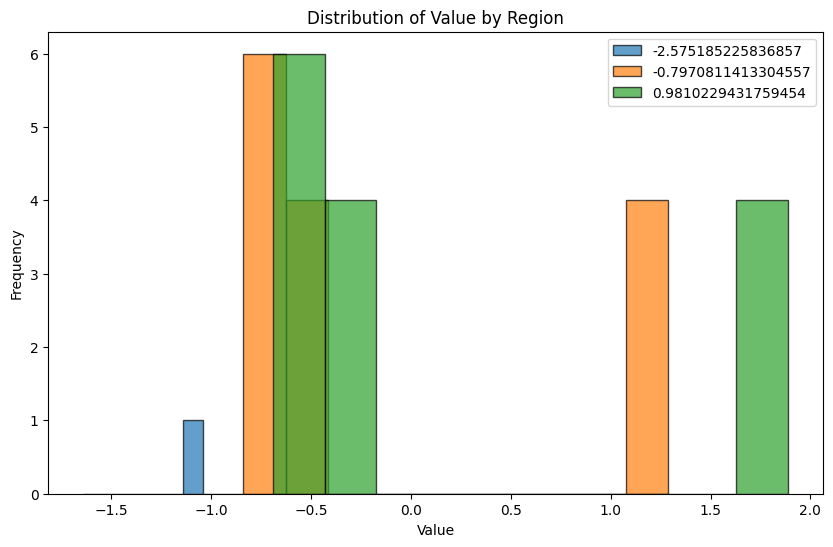

In [ ]:
# Data visualizationfor the dataset.

# Group data by region and get the values for each region
region_values = WASDE_DATAE_df.groupby('region')['value'].apply(list).reset_index()

# Create the histogram
plt.figure(figsize=(10, 6))
for index, row in region_values.iterrows():
    plt.hist(row['value'], bins=10, alpha=0.7, label=row['region'], edgecolor='black')

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Value by Region")
plt.legend()
plt.show()

In [ ]:
Explanation:

The histogram graph explains the frequency and the value of commodities of good in the different region of the world. You will notice the bar one has the lowest frequency of 0.99 and the lowest value compared to the other graph. The graph 1 represents the lowest of value of trade of commodities.
You will notice that the bar 2 and 3 that overshadowed each other as the high frequency of 5.9 which the revenue per capita of trade of goods compare to the regions of the world.The bar 4, 5, and 6 have the same frequency of 3.8 which means their values of trade in revenue for goods are the same in their categories.

